# Analysis of results

Packages

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


### Slide 9 - Overall accuracy vs data imbalance

In [105]:
results_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'results.pkl'))
results_naive = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_naive_0.5_0.9', 'results.pkl'))

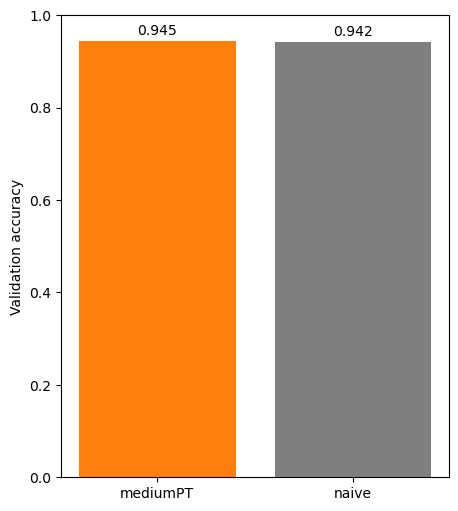

In [106]:
results_dicts = [results_mediumPT, results_naive]
model_names = ['mediumPT', 'naive']
best_epochs = [results['best_epoch'] for results in results_dicts]
val_accs = [results_dicts[i]['val_accs'][best_epochs[i]] for i in range(len(results_dicts))]

fig, ax = plt.subplots(figsize=(5, 6))
bars = ax.bar(model_names, val_accs, color=['tab:orange', 'tab:gray'])
ax.bar_label(bars, fmt='%.3f', padding=2)
ax.set_ylabel('Validation accuracy')
ax.set_ylim(0, 1.0)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_wo_distr.png'), bbox_inches='tight', dpi=300)
plt.show()

In [107]:
ds_NCBI = pd.read_pickle(os.path.join(BASE_DIR, 'data', 'NCBI.pkl'))
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 0].reset_index(drop=True)
ds_MM['num_S'] = ds_MM['phenotypes'].apply(lambda x: len([p for p in x if p.endswith('S')]))
ds_MM['num_R'] = ds_MM['phenotypes'].apply(lambda x: len([p for p in x if p.endswith('R')]))
assert ds_MM['num_S'].sum() + ds_MM['num_R'].sum() == ds_MM['num_ab'].sum()

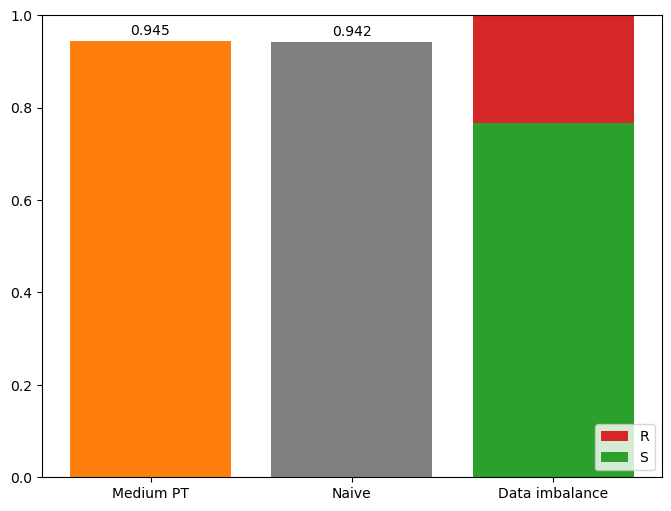

In [108]:
results_dicts = [results_mediumPT, results_naive]
model_names = ['Medium PT', 'Naive']
best_epochs = [results['best_epoch'] for results in results_dicts]
val_accs = [results_dicts[i]['val_accs'][best_epochs[i]] for i in range(len(results_dicts))]

frac_S = ds_MM['num_S'].sum() / ds_MM['num_ab'].sum()
frac_R = ds_MM['num_R'].sum() / ds_MM['num_ab'].sum()

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(model_names, val_accs, color=['tab:orange', 'tab:gray'])
bar1 = ax.bar('Data imbalance', [frac_R], bottom=[frac_S], color='tab:red', label='R')
bar2 = ax.bar('Data imbalance', [frac_S], color='tab:green', label='S')
ax.bar_label(bars, fmt='%.3f', padding=2)
ax.set_ylim(0, 1.0)
plt.legend(loc='lower right')
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_vs_distr.png'), bbox_inches='tight', dpi=300)
plt.show()

### Slide 11 - Isolate accuracy at different masking probabilities

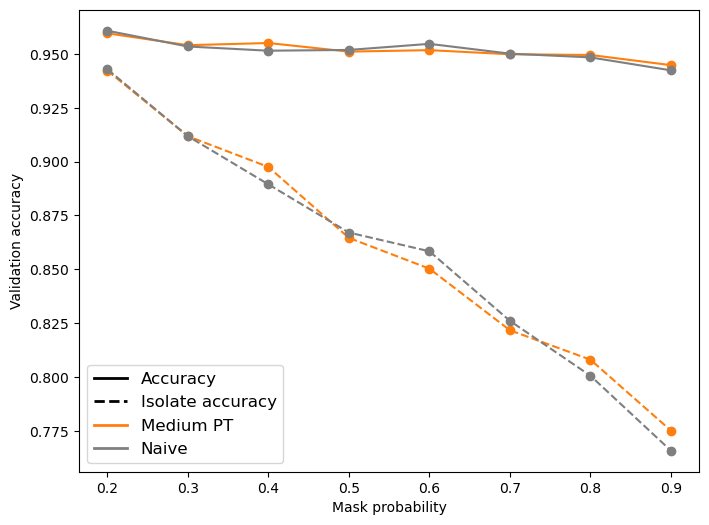

In [109]:
mask_probs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
medium_accs = []
medium_iso_accs = []
naive_accs = []
naive_iso_accs = []
for i in range(len(mask_probs)):
    medium_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_mediumPT_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = medium_results['best_epoch']
    medium_accs.append(medium_results['val_accs'][best_epoch])
    medium_iso_accs.append(medium_results['val_iso_accs'][best_epoch])
    
    naive_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_naive_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = naive_results['best_epoch']
    naive_accs.append(naive_results['val_accs'][best_epoch])
    naive_iso_accs.append(naive_results['val_iso_accs'][best_epoch])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_accs, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, medium_iso_accs, "--o",  color='tab:orange', label='Medium PT (iso_acc)')
ax.plot(mask_probs, naive_accs, "-o", color='tab:gray', label='Naive')
ax.plot(mask_probs, naive_iso_accs, "--o", color='tab:gray', label='Naive (iso_acc)')
ax.set_xlabel('Mask probability')
ax.set_ylabel('Validation accuracy')

acc_line = Line2D([0], [0], color='black', linestyle='-', label='Accuracy', lw=2)
iso_acc_line = Line2D([0], [0], color='black', linestyle='--', label='Isolate accuracy', lw=2)
medium_line = Line2D([0], [0], color='tab:orange', linestyle='-', label='Medium PT', lw=2)
naive_line = Line2D([0], [0], color='tab:gray', linestyle='-', label='Naive', lw=2)
ax.legend(handles=[acc_line, iso_acc_line, medium_line, naive_line], fontsize=12)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_vs_mask.png'), bbox_inches='tight', dpi=300)
plt.show()

### Slide 12 - Isolate accuracy against number/share of antibiotics masked


In [110]:
results_medium = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.8', 'results.pkl'))
results_naive = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_naive_0.5_0.8', 'results.pkl'))
medium_iso_stats = results_medium['val_iso_stats']
naive_iso_stats = results_naive['val_iso_stats']
medium_iso_stats['num_ab'] = medium_iso_stats['num_ab'].astype(int)
naive_iso_stats['num_ab'] = naive_iso_stats['num_ab'].astype(int)

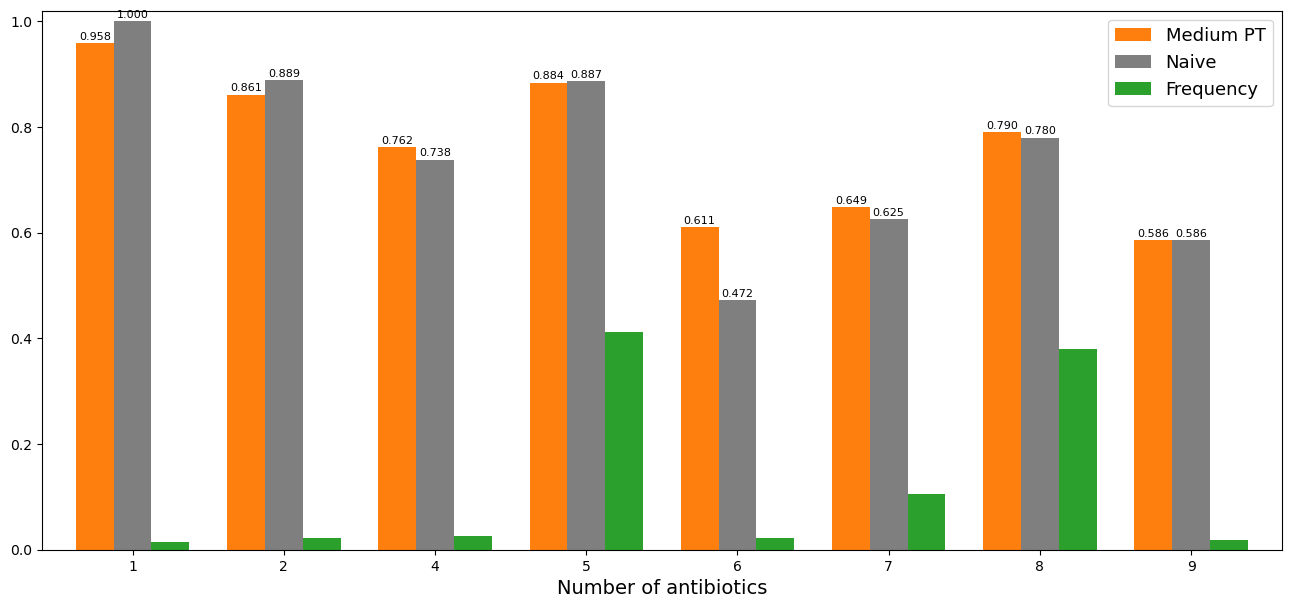

In [111]:
df_tmp = medium_iso_stats.groupby('num_ab').agg({'all_correct': ['mean', 'count']})
df_tmp.columns = ['accuracy', 'count']
df_tmp_naive = naive_iso_stats.groupby('num_ab').agg({'all_correct': ['mean', 'count']})
df_tmp_naive.columns = ['accuracy', 'count']
df_tmp = df_tmp[df_tmp['count'] > 20]
df_tmp_naive = df_tmp_naive[df_tmp_naive['count'] > 20]
df_tmp['share'] = df_tmp['count'] / df_tmp['count'].sum()

fig, ax = plt.subplots(figsize=(16, 7))
ind = np.arange(df_tmp.shape[0])
bar_width = 0.25
bar1 = ax.bar(ind - bar_width, df_tmp['accuracy'], width=bar_width, color='tab:orange', label='Medium PT')
bar2 = ax.bar(ind, df_tmp_naive['accuracy'], width=bar_width, color='tab:gray', label='Naive')
bar3 = ax.bar(ind + bar_width, df_tmp['share'], width=bar_width, color='tab:green', label='Frequency')
ax.bar_label(bar1, fmt='%.3f', padding=1, fontsize=8)
ax.bar_label(bar2, fmt='%.3f', padding=1, fontsize=8)

ax.set_xlabel('Number of antibiotics', fontsize=14)
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.6, df_tmp.shape[0] - 0.4)
ax.set_xticks(ind)
ax.set_xticklabels(df_tmp.index)

plt.legend(loc='upper right', fontsize=13)
plt.show()

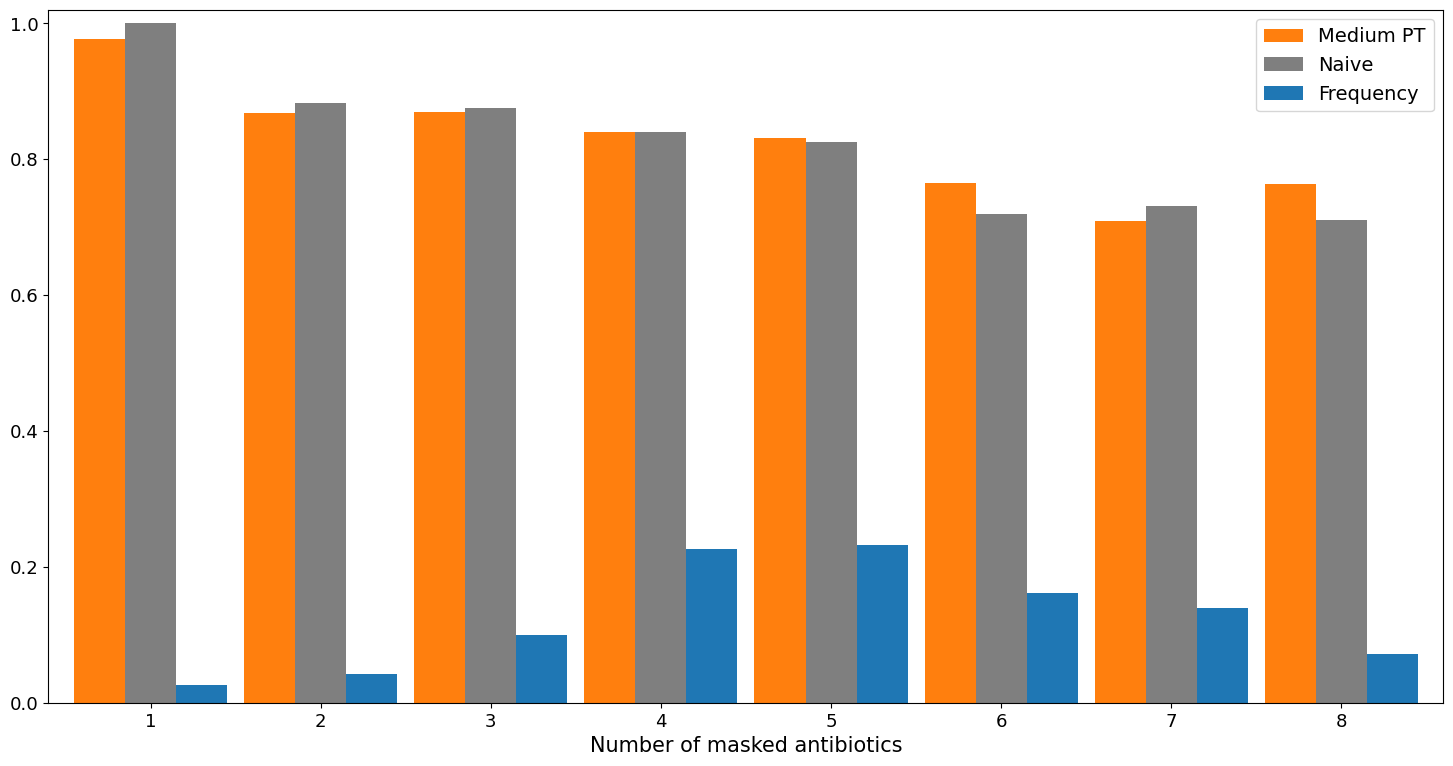

In [116]:
df_tmp = medium_iso_stats.groupby('num_masked').agg({'all_correct': ['mean', 'count']})
df_tmp.columns = ['accuracy', 'count']
df_tmp_naive = naive_iso_stats.groupby('num_masked').agg({'all_correct': ['mean', 'count']})
df_tmp_naive.columns = ['accuracy', 'count']
df_tmp = df_tmp[df_tmp['count'] > 10]
df_tmp_naive = df_tmp_naive[df_tmp_naive['count'] > 10]
df_tmp['share'] = df_tmp['count'] / df_tmp['count'].sum()

fig, ax = plt.subplots(figsize=(18, 9))
ind = np.arange(df_tmp.shape[0])
bar_width = 0.3
bar1 = ax.bar(ind - bar_width, df_tmp['accuracy'], width=bar_width, color='tab:orange', label='Medium PT')
bar2 = ax.bar(ind, df_tmp_naive['accuracy'], width=bar_width, color='tab:gray', label='Naive')
bar3 = ax.bar(ind + bar_width, df_tmp['share'], width=bar_width, color='tab:blue', label='Frequency')
# ax.bar_label(bar1, fmt='%.3f', padding=1, fontsize=10)
# ax.bar_label(bar2, fmt='%.3f', padding=1, fontsize=10)

ax.set_xlabel('Number of masked antibiotics', fontsize=15)
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.6, df_tmp.shape[0] - 0.4)
ax.set_xticks(ind)
ax.set_xticklabels(df_tmp.index, fontsize=13)
ax.tick_params(axis='y', labelsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'iso_accs_vs_num_masked.png'), bbox_inches='tight', dpi=300)
plt.show()

### Slide 13 - Sensitivity, Specificity, F1 at different probabilities

In [121]:
def get_sensitivities(results_dict):
    sensitivities = []
    ab_stats = results_dict['val_ab_stats']
    sensitivities.append(ab_stats['num_correct_R'].sum() / ab_stats['num_R'].sum())
    return sensitivities

def get_specificities(results_dict):
    specificities = []
    ab_stats = results_dict['val_ab_stats']
    specificities.append(ab_stats['num_correct_S'].sum() / ab_stats['num_S'].sum())
    return specificities

def get_F1_scores(results_dict):
    F1_scores = []
    ab_stats = results_dict['val_ab_stats']
    sensitivity = ab_stats['num_correct_R'].sum() / ab_stats['num_R'].sum()
    precision = ab_stats['num_correct_R'].sum() / ab_stats['num_pred_R'].sum()
    F1_scores.append(2 * sensitivity * precision / (sensitivity + precision))
    return F1_scores

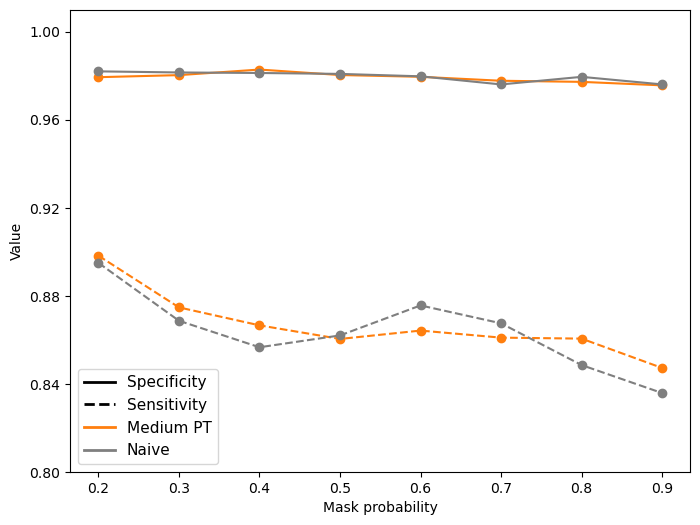

In [149]:
mask_probs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
medium_sensitivities = []
medium_specificities = []
medium_F1_scores = []
naive_sensitivities = []
naive_specificities = []
naive_F1_scores = []
for i in range(len(mask_probs)):
    medium_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_mediumPT_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = medium_results['best_epoch']
    medium_sensitivities.append(get_sensitivities(medium_results))
    medium_specificities.append(get_specificities(medium_results))
    medium_F1_scores.append(get_F1_scores(medium_results))
    
    naive_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_naive_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = naive_results['best_epoch']
    naive_sensitivities.append(get_sensitivities(naive_results))
    naive_specificities.append(get_specificities(naive_results))
    naive_F1_scores.append(get_F1_scores(naive_results))
    

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_specificities, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, naive_specificities, "-o", color='tab:gray', label='Naive')
ax.plot(mask_probs, medium_sensitivities, "--o", color='tab:orange', label='Medium PT (sensitivity)')
ax.plot(mask_probs, naive_sensitivities, "--o", color='tab:gray', label='Naive (sensitivity)')

ax.set_xlabel('Mask probability')
ax.set_ylabel('Value')
ax.set_ylim(0.8, 1.01)

spec_line = Line2D([0], [0], color='black', linestyle='-', label='Specificity', lw=2)
sens_line = Line2D([0], [0], color='black', linestyle='--', label='Sensitivity', lw=2)
medium_line = Line2D([0], [0], color='tab:orange', linestyle='-', label='Medium PT', lw=2)
naive_line = Line2D([0], [0], color='tab:gray', linestyle='-', label='Naive', lw=2)
ax.legend(handles=[spec_line, sens_line, medium_line, naive_line], fontsize=11)
ax.set_yticks(np.arange(0.8, 1.01, 0.04))
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'sens_spec_vs_prob.png'), bbox_inches='tight', dpi=300)
plt.show()

### Slide 14 - F1 scores / F1 scores and sensitivity

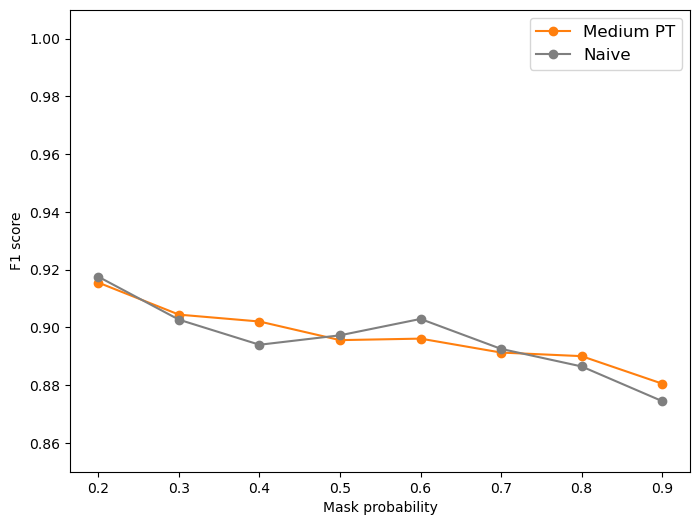

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_F1_scores, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, naive_F1_scores, "-o", color='tab:gray', label='Naive')

ax.set_xlabel('Mask probability')
ax.set_ylabel('F1 score')
ax.set_ylim(0.85, 1.01)

ax.legend(fontsize=12)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'F1_vs_probs.png'), bbox_inches='tight', dpi=300)
plt.show()

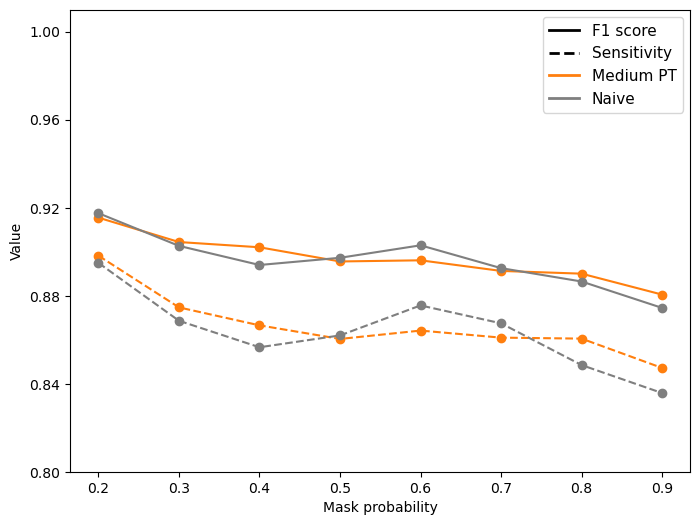

In [152]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_F1_scores, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, naive_F1_scores, "-o", color='tab:gray', label='Naive')
ax.plot(mask_probs, medium_sensitivities, "--o", color='tab:orange', label='Medium PT (sensitivity)')
ax.plot(mask_probs, naive_sensitivities, "--o", color='tab:gray', label='Naive (sensitivity)')

ax.set_xlabel('Mask probability')
ax.set_ylabel('Value')
ax.set_ylim(0.8, 1.01)

spec_line = Line2D([0], [0], color='black', linestyle='-', label='F1 score', lw=2)
sens_line = Line2D([0], [0], color='black', linestyle='--', label='Sensitivity', lw=2)
medium_line = Line2D([0], [0], color='tab:orange', linestyle='-', label='Medium PT', lw=2)
naive_line = Line2D([0], [0], color='tab:gray', linestyle='-', label='Naive', lw=2)
ax.legend(handles=[spec_line, sens_line, medium_line, naive_line], fontsize=11)
ax.set_yticks(np.arange(0.8, 1.01, 0.04))
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'sens_F1_vs_prob.png'), bbox_inches='tight', dpi=300)
plt.show()

### Slide 15 - Antibiotic level